## Reset Previous Work

In [1]:
import importlib
import time
from tqdm import trange
import pandas as pd
from collections import Counter
import numpy as np
from Bio import SeqIO

from MERFISH_Objects.execute_class import *
import shutil
cword_config = 'merfish_config_zebrafinch_24bits'
config = importlib.import_module(cword_config)

2022-08-24 15:11:16,597 [INFO] WRITING LOG OUTPUT TO /home/fangming/.cellpose/run.log


In [2]:
metadata_path = '/bigstore/Images2022/Gaby/Zebrafinch/Zebra_B0_2022Jul11/'
dataset = [i for i in metadata_path.split('/') if not i==''][-1]
parameters = config.parameters
fishdata_path = os.path.join(metadata_path, parameters['fishdata'])
utilities_path = parameters['utilities_path']
bitmap = config.bitmap

for key in parameters:
    if key.endswith('path') or key.endswith('data'):
        print(key, parameters[key])

daemon_path /scratch/test_daemon_FX_24bits
utilities_path /scratch/test_utility_FX_24bits
fishdata fishdata_testFX_24bits


In [3]:
bitmap

[('RS0095_cy5', 'hybe1', 'FarRed'),
 ('RS0109_cy5', 'hybe2', 'FarRed'),
 ('RS0175_cy5', 'hybe3', 'FarRed'),
 ('RS0237_cy5', 'hybe4', 'FarRed'),
 ('RS0307_cy5', 'hybe5', 'FarRed'),
 ('RS0332_cy5', 'hybe6', 'FarRed'),
 ('RSN9927.0_cy5', 'hybe7', 'FarRed'),
 ('RSN2336.0_cy5', 'hybe8', 'FarRed'),
 ('RSN1807.0_cy5', 'hybe9', 'FarRed'),
 ('RS0384_cy5', 'hybe10', 'FarRed'),
 ('RS0406_cy5', 'hybe11', 'FarRed'),
 ('RS0451_cy5', 'hybe12', 'FarRed'),
 ('RS0468_cy5', 'hybe13', 'FarRed'),
 ('RS0548_cy5', 'hybe14', 'FarRed'),
 ('RS64.0_cy5', 'hybe15', 'FarRed'),
 ('RSN4287.0_cy5', 'hybe16', 'FarRed'),
 ('RSN1252.0_cy5', 'hybe17', 'FarRed'),
 ('RSN9535.0_cy5', 'hybe18', 'FarRed'),
 ('RS156.0_cy5', 'hybe19', 'FarRed'),
 ('RS278.0_cy5', 'hybe20', 'FarRed'),
 ('RS313.0_cy5', 'hybe21', 'FarRed'),
 ('RS643.0_cy5', 'hybe22', 'FarRed'),
 ('RS740.0_cy5', 'hybe23', 'FarRed'),
 ('RS810.0_cy5', 'hybe24', 'FarRed')]

In [4]:
posname = '7-Pos004_003'#image_metadata.posnames[0]

### Image

In [5]:
%%time
# init takes sometime
self = Dataset_Class(metadata_path, dataset, cword_config, verbose=True)
self.main()

15:11:17 Checking Imaging: 0it [00:00, ?it/s]
15:11:17 Checking Hot Pixel: 0it [00:00, ?it/s]
15:11:17 Checking Position Flags: 100%|██████████| 150/150 [00:00<00:00, 1833.84it/s]

CPU times: user 106 ms, sys: 24.2 ms, total: 130 ms
Wall time: 181 ms


In [6]:
def pfunc(hybe):
    self = Registration_Class(metadata_path,dataset,posname,hybe,cword_config,verbose=False)
    self.find_beads()

In [7]:
%%time
# takes some time
Input = [hybe for readout_probe,hybe,channel in bitmap if not hybe==parameters['ref_hybe']]
pfunc(parameters['ref_hybe'])
ncpu = 10
pool = multiprocessing.Pool(ncpu)
sys.stdout.flush()
results = pool.imap(pfunc, Input)
iterable = tqdm(results,total=len(Input),desc=str(datetime.now().strftime("%H:%M:%S"))+' '+dataset,position=0)
for i in iterable:
    pass
pool.close()
sys.stdout.flush()

15:12:26 Zebra_B0_2022Jul11: 100%|██████████| 23/23 [05:11<00:00, 13.56s/it]

CPU times: user 38.7 s, sys: 30.1 s, total: 1min 8s
Wall time: 6min 21s


In [8]:
def pfunc(data):
    hybe = data['hybe']
    channel = data['channel']
    zindex = data['zindex']
    self = Image_Class(metadata_path,dataset,posname,hybe,channel,zindex,cword_config,verbose=False)
    self.main()

In [9]:
%%time
Input = []
hybe = 'hybe2'
channel = 'FarRed'
self = Stack_Class(metadata_path,dataset,posname,hybe,channel,cword_config,verbose=False)
self.check_projection()
zindexes = self.zindexes
for readout_probe,hybe,channel in bitmap:
    for zindex in zindexes:
        data = {'hybe':hybe,'channel':channel,'zindex':zindex}
        Input.append(data)

ncpu = 30
pool = multiprocessing.Pool(ncpu)
sys.stdout.flush()
results = pool.imap(pfunc, Input)
iterable = tqdm(results,total=len(Input),desc=str(datetime.now().strftime("%H:%M:%S"))+' '+dataset,position=0)
for i in iterable:
    pass
pool.close()
sys.stdout.flush()

15:17:39 Zebra_B0_2022Jul11: 100%|██████████| 24/24 [09:40<00:00, 24.18s/it]  

CPU times: user 181 ms, sys: 570 ms, total: 751 ms
Wall time: 9min 41s


In [10]:
def plot_image_with_zoom(img, x_window, y_window, vmin_p=0, vmax_p=100, title=''):
    """
    """
    vmin,vmax = np.percentile(img.ravel(),[vmin_p, vmax_p])

    fig, axs = plt.subplots(1, 2, figsize=(10*2,10*1))
    for ax in axs:
        ax.set_title(title)
        g = ax.imshow(img,vmin=vmin,vmax=vmax,cmap='jet')

    ax = axs[0]
    ax.hlines(y_window, xmin=x_window[0], xmax=x_window[1], color='white')
    ax.vlines(x_window, ymin=y_window[0], ymax=y_window[1], color='white')

    ax = axs[1]
    ax.set_xlim(x_window)
    ax.set_ylim(y_window)
    fig.colorbar(g, shrink=0.5, ax=ax)
    plt.show()

In [11]:
x_window = [500,750]
y_window = [1000,1250]

In [12]:
nuclei = [i for i in os.listdir(metadata_path) if 'nucstain' in i][-1]
print(nuclei)
hybe1 = [i for i in os.listdir(metadata_path) if 'hybe1_' in i][-1]
print(hybe1)

image_metadata_nuc = Metadata(os.path.join(metadata_path, nuclei))
print(image_metadata_nuc.posnames.shape)
image_metadata = Metadata(os.path.join(metadata_path, hybe1))
print(image_metadata.posnames.shape)

nucstain_26
hybe1_2
(150,)
(150,)


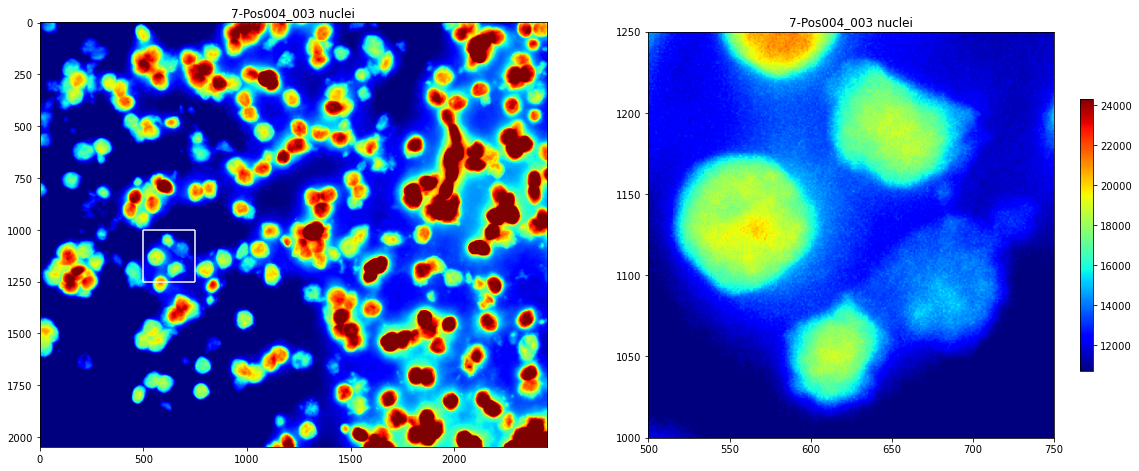

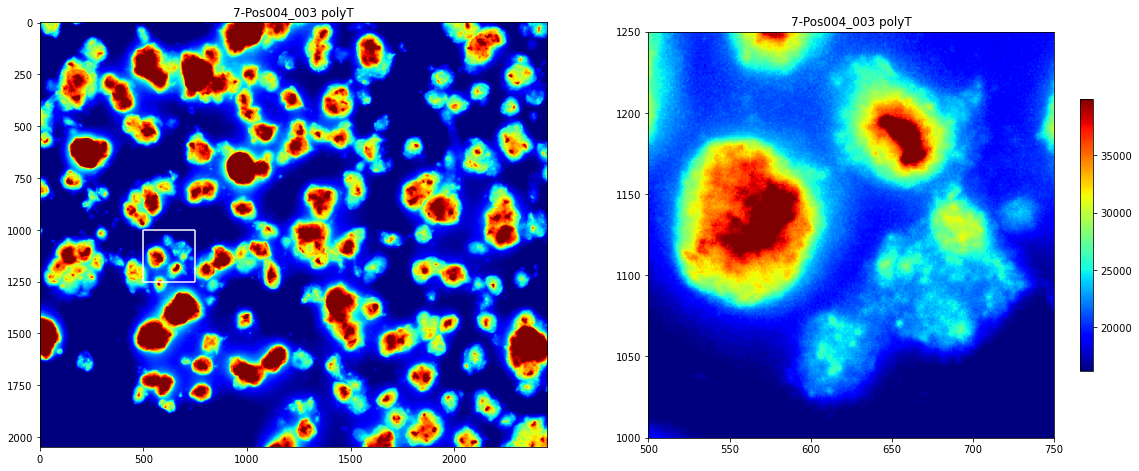

In [13]:
img_nuc = image_metadata_nuc.stkread(Position=posname, Channel='DeepBlue').max(2) # max across z?
plot_image_with_zoom(img_nuc, x_window, y_window, vmin_p=25, vmax_p=95, title=posname+" nuclei")

img_poly = image_metadata_nuc.stkread(Position=posname, Channel='FarRed').max(2) # max across z?
plot_image_with_zoom(img_poly, x_window, y_window, vmin_p=25, vmax_p=95, title=posname+" polyT")

In [14]:
nbits = len(bitmap)
nbits

24

In [15]:
Input = []
hybe = 'hybe2'
channel = 'FarRed'
self = Stack_Class(metadata_path,dataset,posname,hybe,channel,cword_config,verbose=False)
self.check_projection()
zindexes = self.zindexes

x_window = [500,750]
y_window = [1000,1250]

In [16]:
%%time
zindex = str(zindexes[0])
# stks = {}

# raw_dapis = {}

rawimgs = {}
imgs = {}
spots_coords = {}
spots_coords_v2 = {}

for i, (readout,hybe,channel) in enumerate(bitmap):
    print(readout,hybe,channel)
    """ Processed Image Zoom"""
    # self = Image_Class(metadata_path,dataset,posname,hybe,'DeepBlue',zindex,cword_config,verbose=False)
    # self.load_data() # sub_stk
    # self.project() # max projection
    # raw_dapis[i] = self.img # are these correct?
    
    self = Image_Class(metadata_path,dataset,posname,hybe,channel,zindex,cword_config,verbose=False)
    self.load_data() # sub_stk
    # stks[i] = self.sub_stk
    self.project() # max projection
    rawimgs[i] = self.img
    
    fish_img = self.fishdata.load_data('image',
                                        dataset=self.dataset,
                                        posname=self.posname,
                                        hybe=self.hybe,
                                        channel=self.channel,
                                        zindex=self.zindex)/self.parameters['gain']
    imgs[i] = fish_img
    self.img = fish_img # trying this and see; this is important
    
    self.parameters['spot_max_distance'] = 3#self.parameters['spot_parameters']['default']['spot_max_distance']
    self.parameters['spot_minmass'] = 5#self.parameters['spot_parameters']['default']['spot_minmass']
    self.parameters['spot_diameter'] = 5#self.parameters['spot_parameters']['default']['spot_diameter']
    self.parameters['spot_separation'] = 3#self.parameters['spot_parameters']['default']['spot_separation']
    self.call_spots()
    spots_coords[i] = np.vstack([self.spots.x, self.spots.y]).T

    self.parameters['spot_max_distance'] = 3#self.parameters['spot_parameters']['default']['spot_max_distance']
    self.parameters['spot_minmass'] = 10#self.parameters['spot_parameters']['default']['spot_minmass']
    self.parameters['spot_diameter'] = 5#self.parameters['spot_parameters']['default']['spot_diameter']
    self.parameters['spot_separation'] = 3#self.parameters['spot_parameters']['default']['spot_separation']
    self.call_spots()
    spots_coords_v2[i] = np.vstack([self.spots.x, self.spots.y]).T

RS0095_cy5 hybe1 FarRed
RS0109_cy5 hybe2 FarRed
RS0175_cy5 hybe3 FarRed
RS0237_cy5 hybe4 FarRed
RS0307_cy5 hybe5 FarRed
RS0332_cy5 hybe6 FarRed
RSN9927.0_cy5 hybe7 FarRed
RSN2336.0_cy5 hybe8 FarRed
RSN1807.0_cy5 hybe9 FarRed
RS0384_cy5 hybe10 FarRed
RS0406_cy5 hybe11 FarRed
RS0451_cy5 hybe12 FarRed
RS0468_cy5 hybe13 FarRed
RS0548_cy5 hybe14 FarRed
RS64.0_cy5 hybe15 FarRed
RSN4287.0_cy5 hybe16 FarRed
RSN1252.0_cy5 hybe17 FarRed
RSN9535.0_cy5 hybe18 FarRed
RS156.0_cy5 hybe19 FarRed
RS278.0_cy5 hybe20 FarRed
RS313.0_cy5 hybe21 FarRed
RS643.0_cy5 hybe22 FarRed
RS740.0_cy5 hybe23 FarRed
RS810.0_cy5 hybe24 FarRed
CPU times: user 1min 23s, sys: 6min 55s, total: 8min 18s
Wall time: 8min 23s


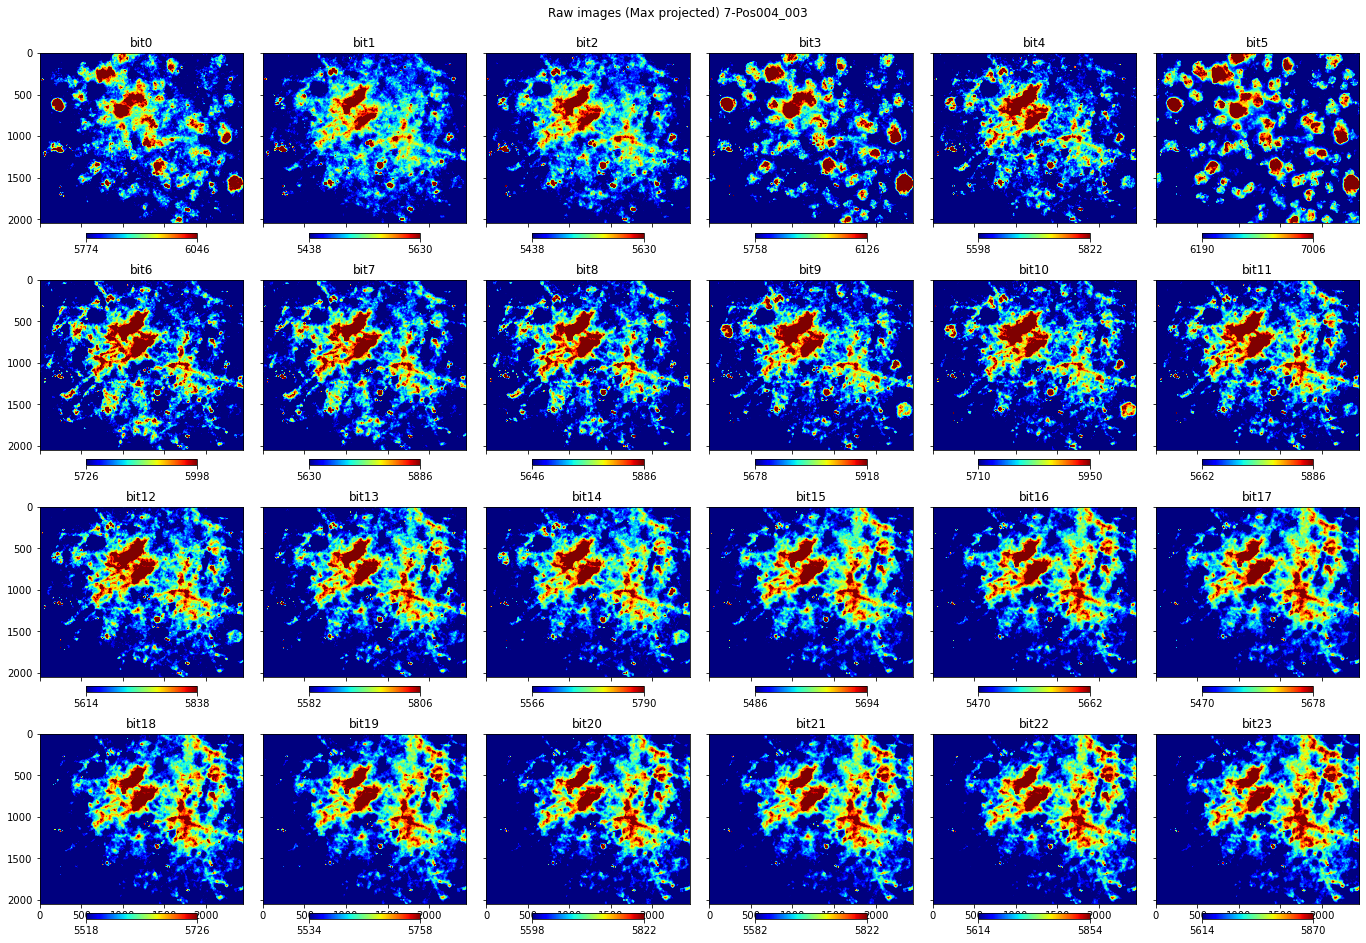

In [17]:
fig, axs = plt.subplots(4,6,figsize=(4*6,4*4), sharex=True, sharey=True)
for i, ax in zip(rawimgs.keys(), axs.flat):
    img = rawimgs[i]
    vmin = np.percentile(img.reshape(-1,), 50)
    vmax = np.percentile(img.reshape(-1,), 95)
    g = ax.imshow(img, cmap='jet', vmin=vmin, vmax=vmax)
    ax.set_aspect('equal')
    ax.set_title(f'bit{i}')
    fig.colorbar(g, ax=ax, shrink=0.5, location='bottom', pad=0.05, fraction=0.05, ticks=[vmin, vmax])
fig.subplots_adjust(wspace=0)
fig.suptitle(f"Raw images (Max projected) {posname}", y=0.92)
plt.show()

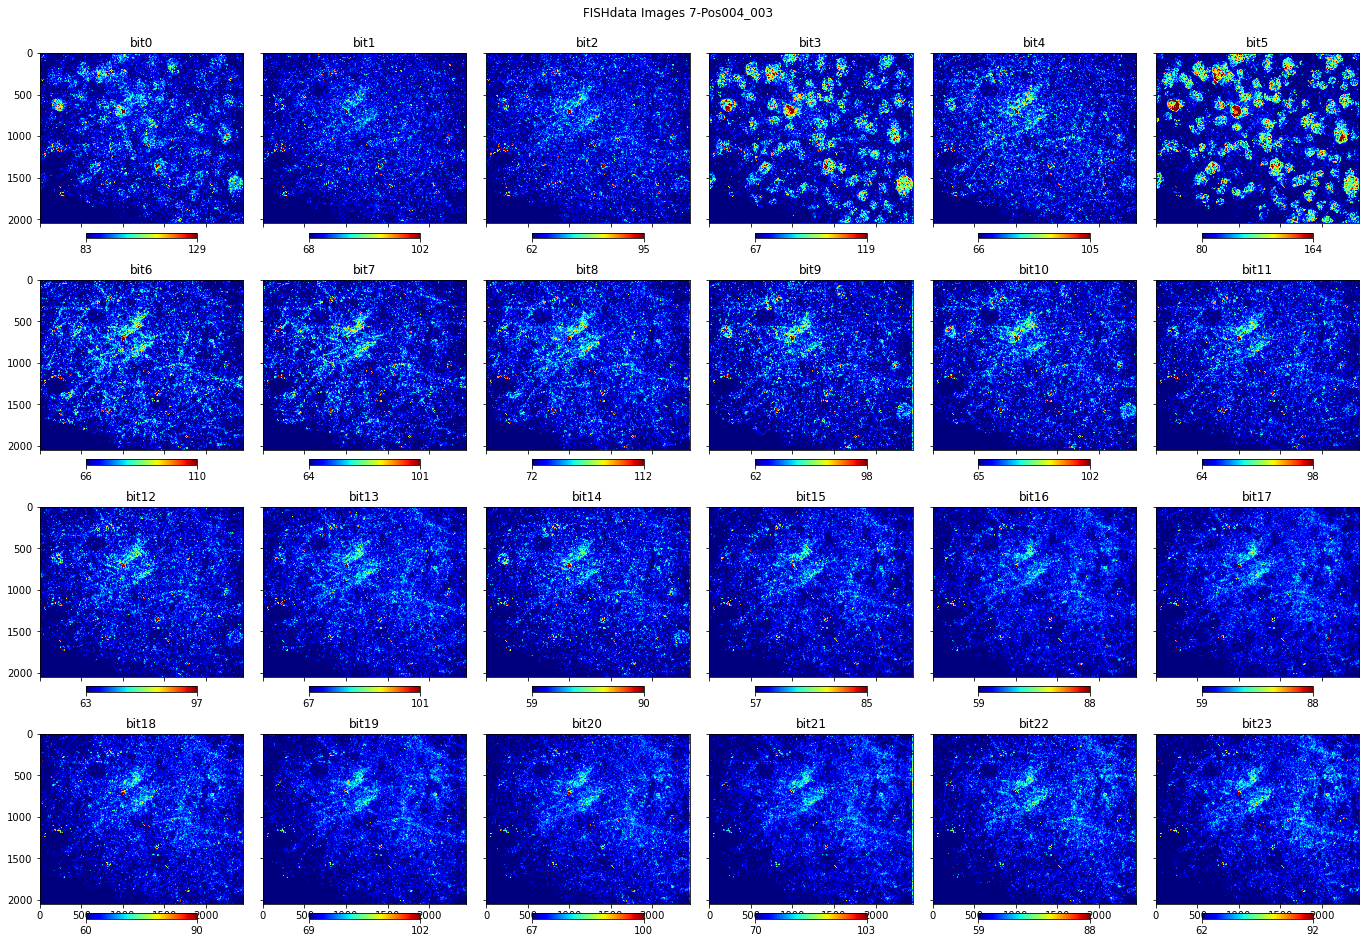

In [18]:
fig, axs = plt.subplots(4,6,figsize=(4*6,4*4), sharex=True, sharey=True)
for i, ax in zip(imgs.keys(), axs.flat):
    img = imgs[i]
    vmin = np.percentile(img.reshape(-1,), 50)
    vmax = np.percentile(img.reshape(-1,), 95)
    g = ax.imshow(img, cmap='jet', vmin=vmin, vmax=vmax)
    ax.set_aspect('equal')
    ax.set_title(f'bit{i}')
    fig.colorbar(g, ax=ax, shrink=0.5, location='bottom', pad=0.05, fraction=0.05, ticks=[vmin, vmax])
fig.subplots_adjust(wspace=0)
fig.suptitle(f"FISHdata Images {posname}", y=0.92)
plt.show()

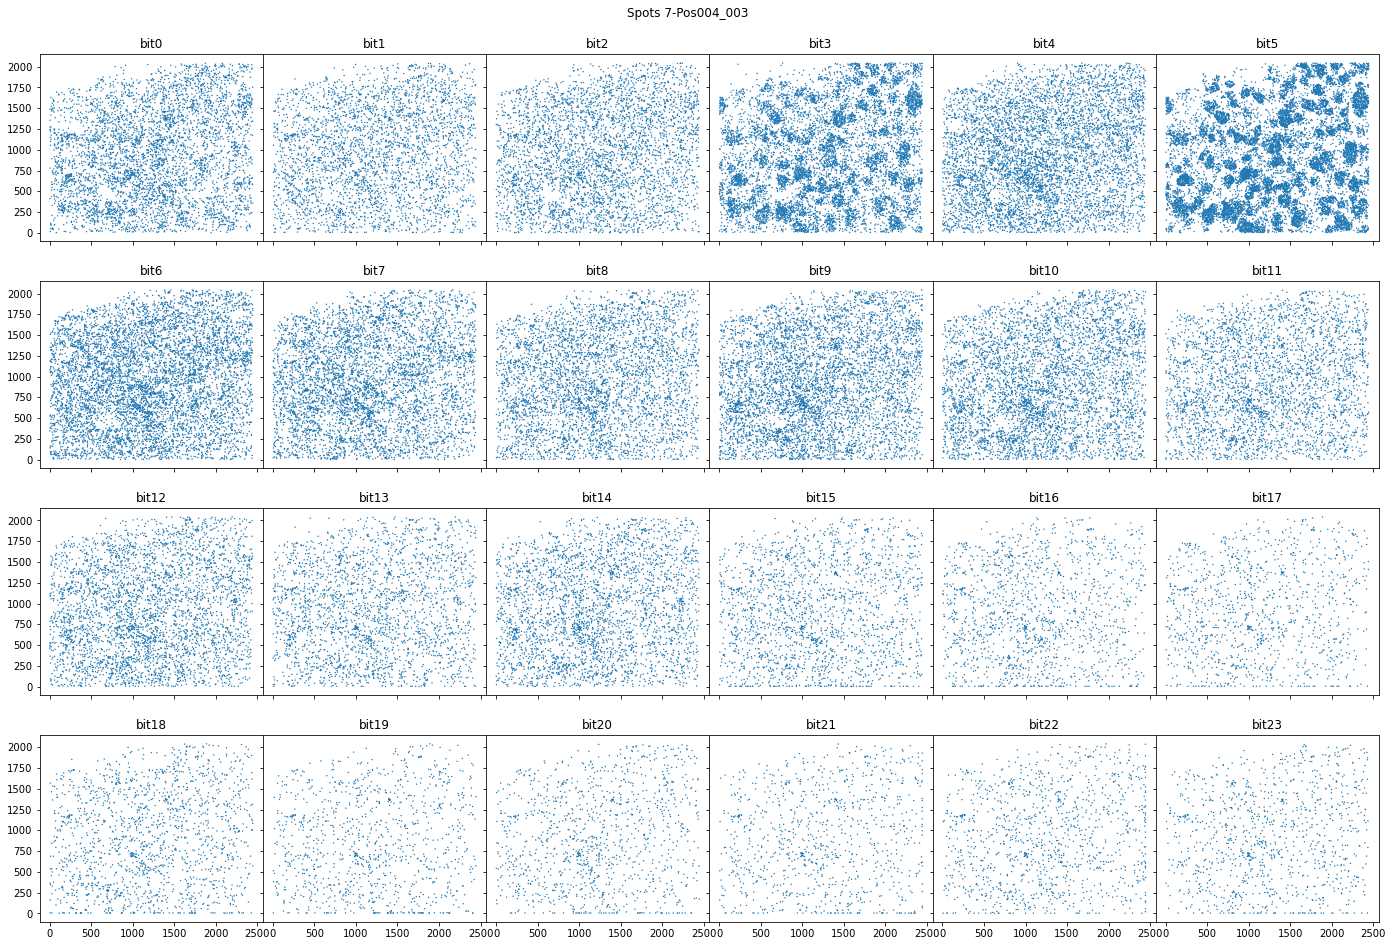

In [19]:
fig, axs = plt.subplots(4,6,figsize=(4*6,4*4), sharex=True, sharey=True)
for i, ax in zip(spots_coords.keys(), axs.flat):
    spots = spots_coords[i]
    ax.scatter(spots[:,0], spots[:,1], s=2, edgecolor='none')
    ax.set_aspect('equal')
    ax.set_title(f'bit{i}')
fig.subplots_adjust(wspace=0)
fig.suptitle(f"Spots {posname}", y=0.92)
plt.show()

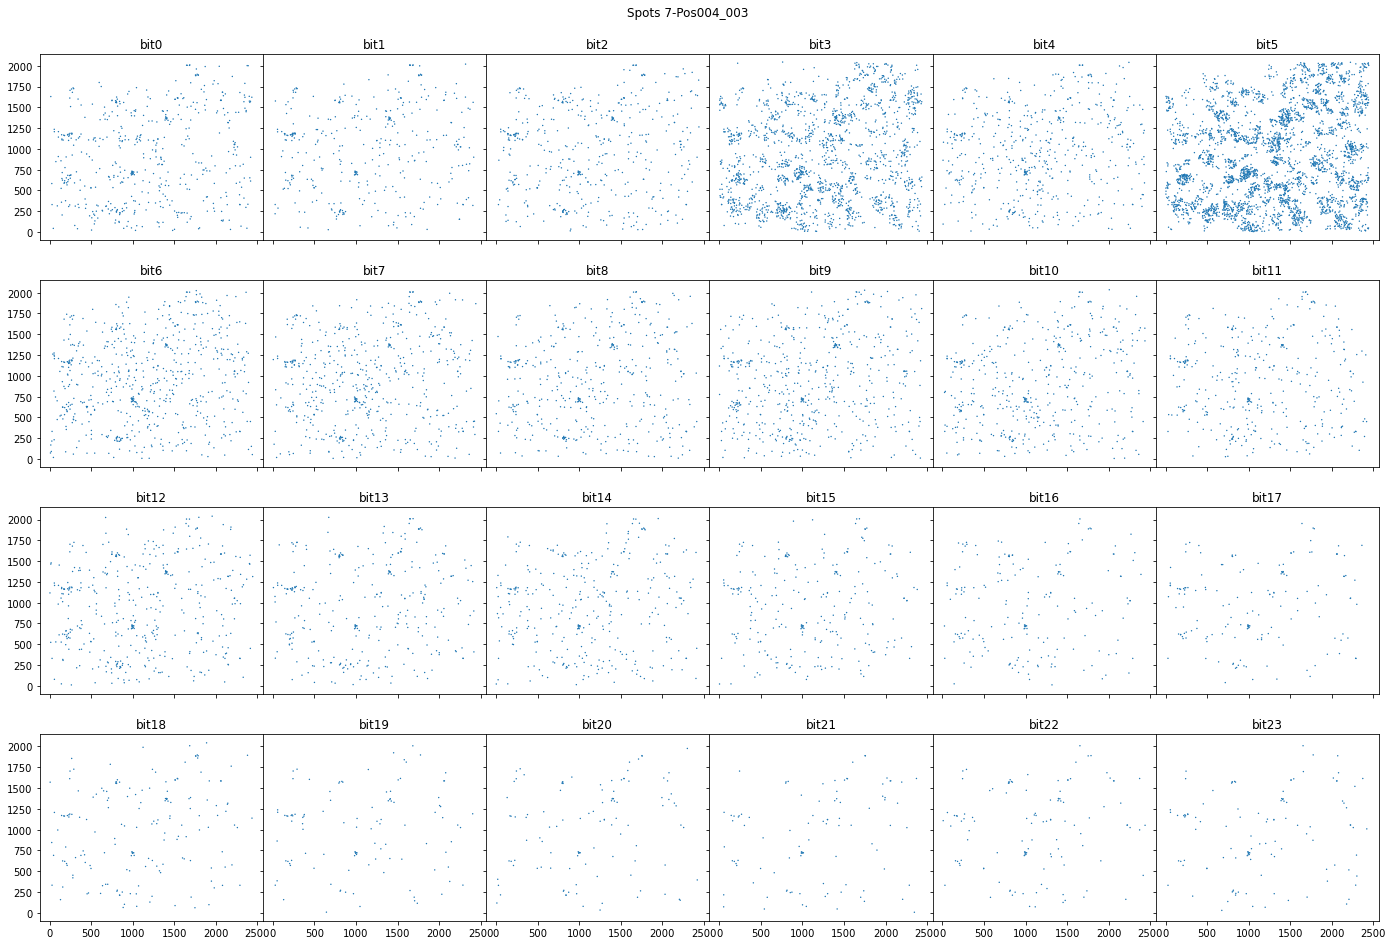

In [20]:
fig, axs = plt.subplots(4,6,figsize=(4*6,4*4), sharex=True, sharey=True)
for i, ax in zip(spots_coords.keys(), axs.flat):
    spots = spots_coords_v2[i]
    ax.scatter(spots[:,0], spots[:,1], s=2, edgecolor='none')
    ax.set_aspect('equal')
    ax.set_title(f'bit{i}')
fig.subplots_adjust(wspace=0)
fig.suptitle(f"Spots {posname}", y=0.92)
plt.show()

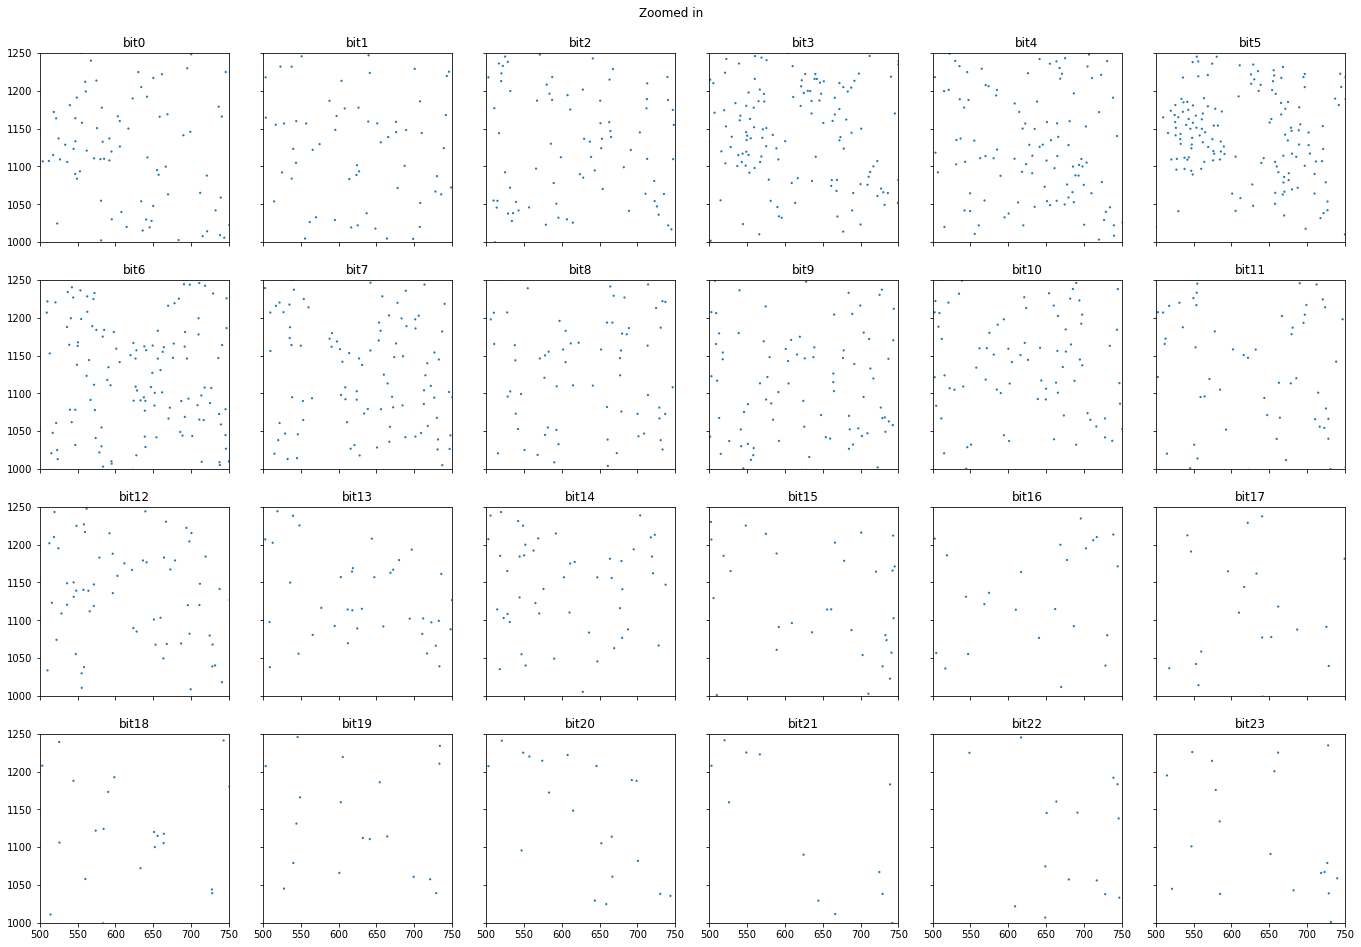

In [21]:
fig, axs = plt.subplots(4,6,figsize=(4*6,4*4), sharex=True, sharey=True)
for i, ax in zip(spots_coords.keys(), axs.flat):
    spots = spots_coords[i]
    ax.scatter(spots[:,0], spots[:,1], s=5, edgecolor='none')
    ax.set_aspect('equal')
    ax.set_title(f'bit{i}')
    ax.set_xlim(x_window)
    ax.set_ylim(y_window)
fig.subplots_adjust(wspace=0)
fig.suptitle("Zoomed in", y=0.92)
plt.show()

In [22]:
%%time
self = Classify_Class(metadata_path,dataset,posname,zindex,cword_config,verbose=True)
self.parameters['spot_max_distance'] = 20
self.parameters['spot_minmass'] = 5
self.parameters['spot_diameter'] = 5
self.parameters['spot_separation'] = 5

self.call_spots()
self.pair_spots()
self.build_barcodes()
self.assign_codewords()

Calling Spots: 100%|██████████| 24/24 [01:16<00:00,  3.20s/it]
15:38:12 95048 Spots Found: 0it [00:00, ?it/s]
15:38:12 Pairing spots: 0it [00:00, ?it/s]
100%|██████████| 2/2 [00:00<00:00, 817.28it/s]
15:39:48 69020 Spots Remaining: 0it [00:00, ?it/s]
15:39:48 30023 Potential Transcripts Found: 0it [00:00, ?it/s]
15:39:48 Building Barcodes: 0it [00:00, ?it/s]
15:39:48 Assigning Codewords: 0it [00:00, ?it/s]
Building Vector: 100%|██████████| 30023/30023 [00:40<00:00, 747.26it/s]
15:40:28 Updating Binary: 0it [00:00, ?it/s]
100%|██████████| 24/24 [00:00<00:00, 38.62it/s]
15:40:29 3754 Transcripts Found: 0it [00:00, ?it/s]
15:40:29 Collapsing Spots: 0it [00:00, ?it/s]
  0%|          | 0/3754 [00:00<?, ?it/s]


TypeError: unsupported operand type(s) for -: 'float' and 'str'

In [ ]:
self.collapse_spots()